In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import torch.optim as optim 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps
%matplotlib inline
from torch.autograd import Variable

#importing Fashion Mnist dataset
transform_list = transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean=[0.0], std=[1.0,]) ] )
mnist_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_list)
mnist_testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_list)

X_train = mnist_trainset.data.numpy()
y_train = mnist_trainset.targets.numpy()
X_test = mnist_testset.data.numpy()
y_test = mnist_testset.targets.numpy()

#smaller dataset to test proof of concept
X_train = X_train[:5000,:,:]
y_train = y_train[:5000]
X_test = X_test[:3000,:,:]
y_test = y_test[:3000]

print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)


(5000,)
(5000, 28, 28)
(3000,)
(3000, 28, 28)


In [2]:
#Hyper parameters
input_dim = 28*28
hidden_layer = [300,200]
output_layer = 10
learning_rate = 0.0001
ran_state = 301
epochs = 100

In [3]:
#first Neural Network
class N_Net( nn.Module ):    
    def __init__(self):
        super(N_Net, self).__init__()
        self.layers = nn.Sequential( 
            nn.Flatten(), 
            nn.Linear(input_dim,hidden_layer[0]),
            nn.ReLU(),
            nn.Linear(hidden_layer[0], hidden_layer[1]), 
            nn.ReLU(),
            nn.Linear(hidden_layer[1], output_layer),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x1 = self.layers(x)
        return x1

In [4]:
#cross conformal prediction for Neural Network
from sklearn.model_selection import KFold 
kf = KFold(shuffle=True, random_state=ran_state) 

def cross_conformal_predictor(X_train,X_test,y_train):
    rank_of_folds = None
    for rest_i, fold_i in kf.split(X_train):
        X_rest, X_fold = X_train[rest_i], X_train[fold_i]
        y_rest, y_fold = y_train[rest_i], y_train[fold_i] 
        c_score_fold = n_Net(X_fold).numpy()
        c_score_one = n_Net(X_test).numpy()
        rank_fold = None
        for each in c_score_one:
            rank = np.sum(c_score_fold<each,0)+1
            if rank_fold is None:
                rank_fold = [rank-1]
            else:
                rank_fold = np.vstack((rank_fold,[rank-1]))
        if rank_of_folds is None:
            rank_of_folds = [rank_fold]
        else:
            rank_of_folds = np.vstack((rank_of_folds, [rank_fold]))
    sum_ranks = np.sum(rank_of_folds,0)
    p_values = (sum_ranks+1)/len(y_train)
    return(p_values) 

In [5]:
#calculating accuracy and loss
X_train_nn = Variable(torch.from_numpy(X_train)).float()
y_train_nn = Variable(torch.from_numpy(y_train)).long()
X_test_nn  = Variable(torch.from_numpy(X_test)).float()
y_test_nn  = Variable(torch.from_numpy(y_test)).long()

n_Net = N_Net()

loss_train = np.zeros((epochs,))

accuracy_test_CCP_NN = np.zeros((epochs,))
accuracy_test_CCP_True = np.zeros((epochs,))
accuracy_test_NN_True = np.zeros((epochs,))

optimizer1 = optim.RMSprop( n_Net.parameters(), lr=learning_rate )
loss_function = nn.CrossEntropyLoss() 
true_test_label = y_test_nn.numpy()

for epoch in range(epochs):
    optimizer1.zero_grad()
    y_pred_train_NN = n_Net(X_train_nn)
    loss_NN = loss_function(y_pred_train_NN, y_train_nn)
    loss_train[epoch] = loss_NN.item()
    loss_NN.backward()
    optimizer1.step()
        
    with torch.no_grad():
        y_pred_NN = n_Net(X_test_nn).numpy()
        y_p_values_CCP = cross_conformal_predictor(X_train_nn,X_test_nn,y_train_nn)
        y_hat_CCP = np.argmax(y_p_values_CCP,axis=1)

        y_predicted_NN = np.argmax(y_pred_NN,axis = 1)
        accuracy_test_NN_True[epoch] = np.mean(y_predicted_NN==true_test_label)
        accuracy_test_CCP_True[epoch] = np.mean(y_hat_CCP==true_test_label)
        
    
print("\nTraining Loss of the neural network model: ",loss_train[-1])
print("\nAccuracy of the model between True Label and NN: ",accuracy_test_NN_True[-1])
print("\nAccuracy of the model between True Label and CCP: ",accuracy_test_CCP_True[-1])


Training Loss of the neural network model:  0.4486168324947357

Accuracy of the model between True Label and NN:  0.7773333333333333

Accuracy of the model between True Label and CCP:  0.789


Text(0.5, 1.0, 'True Label vs NN')

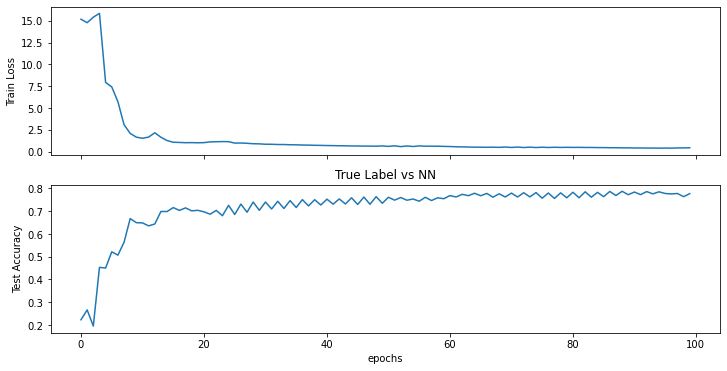

In [6]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
ax1.plot(loss_train)
ax1.set_ylabel("Train Loss")
ax2.plot(accuracy_test_NN_True)
ax2.set_ylabel("Test Accuracy")
ax2.set_xlabel("epochs");
plt.title('True Label vs NN')

Text(0.5, 1.0, 'True Label vs Cross Conformal Prediction')

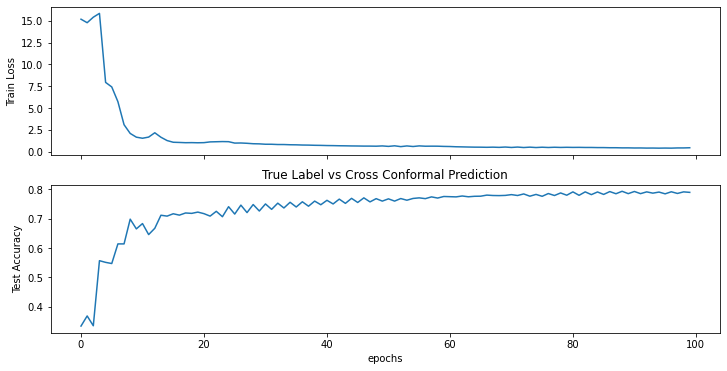

In [7]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(loss_train)
ax1.set_ylabel("Train Loss")
ax2.plot(accuracy_test_CCP_True)
ax2.set_ylabel("Test Accuracy")
ax2.set_xlabel("epochs");
plt.title('True Label vs Cross Conformal Prediction')

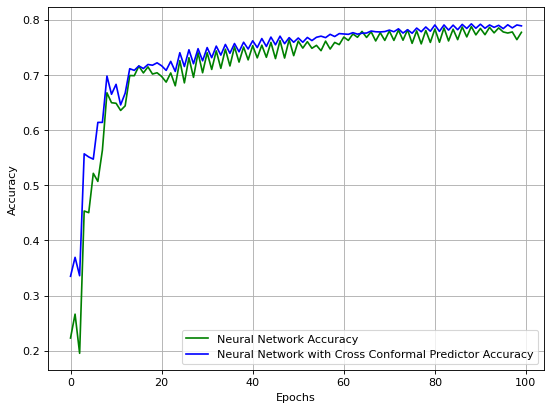

In [8]:
#figure, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

epoch_no = list(range(0, epochs))
plt.plot(epoch_no, accuracy_test_NN_True, color='g')
plt.plot(epoch_no, accuracy_test_CCP_True, color='b')
#plt.xlim([-1,26])
plt.legend(('Neural Network Accuracy','Neural Network with Cross Conformal Predictor Accuracy'))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()